In [1]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

In [2]:
data = pd.read_csv('data/ebay.us.txt')

# Bollinger Bands

<img src="img/bollinger.png"/>

In [3]:
data['TP'] = (data['Open'] + data['High'] + data['Close']) / 3
data

,Date,Open,High,Low,Close,Volume,OpenInt,TP
0,1998-09-24,0.9386,0.9512,0.7744,0.8333,518827162,0,0.907700
1,1998-09-25,0.7997,0.8123,0.7239,0.7870,121461120,0,0.799667
2,1998-09-28,0.8333,0.8923,0.8081,0.8460,89909741,0,0.857200
3,1998-09-29,0.8670,0.8838,0.8375,0.8586,39580358,0,0.869800
4,1998-09-30,0.8291,0.8418,0.7576,0.7912,44227814,0,0.820700
...,...,...,...,...,...,...,...,...
4809,2017-11-06,37.3800,37.6100,37.3000,37.3700,4360973,0,37.453333
4810,2017-11-07,37.6000,37.6000,37.2250,37.4100,5646049,0,37.536667
4811,2017-11-08,37.3000,37.3700,36.9400,37.0100,7092705,0,37.226667
4812,2017-11-09,36.2600,36.3600,35.2100,35.6900,16991775,0,36.103333


In [4]:
n = 20
k = 1
data['UpperBand'] = data['Close'].rolling(n).mean() + k*data['Close'].rolling(n).std()
data['LowerBand'] = data['Close'].rolling(n).mean() - k*data['Close'].rolling(n).std()
data

,Date,Open,High,Low,Close,Volume,OpenInt,TP,UpperBand,LowerBand
0,1998-09-24,0.9386,0.9512,0.7744,0.8333,518827162,0,0.907700,NaN,NaN
1,1998-09-25,0.7997,0.8123,0.7239,0.7870,121461120,0,0.799667,NaN,NaN
2,1998-09-28,0.8333,0.8923,0.8081,0.8460,89909741,0,0.857200,NaN,NaN
3,1998-09-29,0.8670,0.8838,0.8375,0.8586,39580358,0,0.869800,NaN,NaN
4,1998-09-30,0.8291,0.8418,0.7576,0.7912,44227814,0,0.820700,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
4809,2017-11-06,37.3800,37.6100,37.3000,37.3700,4360973,0,37.453333,38.100655,36.911345
4810,2017-11-07,37.6000,37.6000,37.2250,37.4100,5646049,0,37.536667,37.939532,36.929468
4811,2017-11-08,37.3000,37.3700,36.9400,37.0100,7092705,0,37.226667,37.838278,36.900722
4812,2017-11-09,36.2600,36.3600,35.2100,35.6900,16991775,0,36.103333,37.820229,36.678771


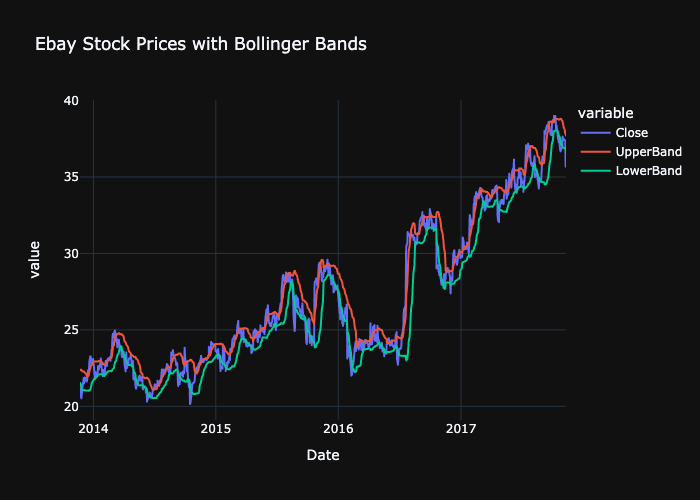

In [5]:
import plotly.express as px

fig = px.line(data[-1000:], x="Date", y=['Close', 'UpperBand', 'LowerBand'],
              title='Ebay Stock Prices with Bollinger Bands')

fig.show('png')

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

data = data.dropna()
X = np.array(data[['UpperBand', 'LowerBand']])[:-3]
y = np.array(data['Close'].shift(-3))[:-3]

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, shuffle=False)
reg = LinearRegression().fit(X_train, y_train)

y_pred = reg.predict(X_test)

from sklearn import metrics

mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print("The model performance for testing set")
print("--------------------------------------")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('R2 score is {}'.format(r2))

The model performance for testing set
--------------------------------------
MAE is 0.8951690973786631
MSE is 1.48454132886433
R2 score is 0.9472106819861753


In [7]:
data_test = data[-len(y_test):]
data_test['PredClose'] = y_pred

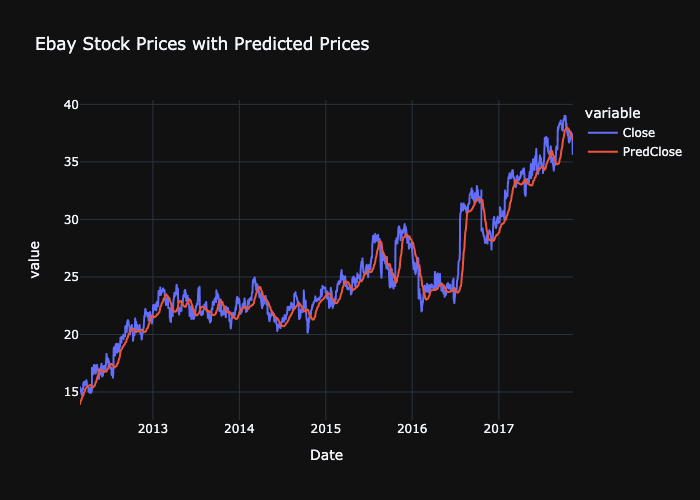

In [9]:
import plotly.express as px

fig = px.line(data_test, x="Date", y=['Close', 'PredClose'],
              title='Ebay Stock Prices with Predicted Prices')

fig.show('png')

# Find Optimal Parameters of Bollinger Bands

In [10]:
def linear_regression(data: pd.DataFrame, n: int, k: int, test_len: int = 0.3, pred_day: int = 3) -> float:
    '''
    :param data: stock prices dataframe
    :param n: number of days in smoothing period
    :param k: number of standard deviation
    :param test_len: dataframe test size
    :param pred_day: predicted day
    :return: linreg mse
    '''
    data['UpperBand'] = data['Close'].rolling(n).mean() + k*data['Close'].rolling(n).std()
    data['LowerBand'] = data['Close'].rolling(n).mean() - k*data['Close'].rolling(n).std()

    data = data.dropna()
    X = np.array(data[['UpperBand', 'LowerBand']])[:-pred_day]
    y = np.array(data['Close'].shift(-pred_day))[:-pred_day]

    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=test_len, shuffle=False)
    reg = LinearRegression().fit(X_train, y_train)

    y_pred = reg.predict(X_test)
    mse = metrics.mean_squared_error(y_test, y_pred)
    return mse, y_pred

In [11]:
opt_mse = 100
opt_n = 0
opt_k = 0
opt_pred = []
for i in range(13, 21):
    for j in range(2, 5):
        mae, y_pred = linear_regression(data, i, j)
        if mae < opt_mse:
            opt_mse = mse
            opt_n = i
            opt_k = j
            opt_pred = y_pred

In [12]:
print("Optimal parameters of Bollinger Bands")
print("--------------------------------------")
print('MSE is {}'.format(opt_mse))
print('n is {}'.format(opt_n))
print('k is {}'.format(opt_k))

Optimal parameters of Bollinger Bands
--------------------------------------
MSE is 1.48454132886433
n is 20
k is 4


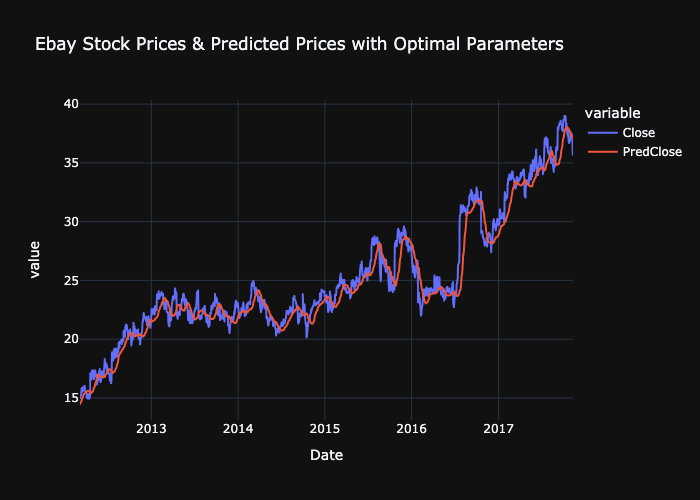

In [13]:
data_test = data[-len(opt_pred):]
data_test['PredClose'] = opt_pred
fig = px.line(data_test, x="Date", y=['Close', 'PredClose'],
              title='Ebay Stock Prices & Predicted Prices with Optimal Parameters')
fig.show('png')

# Dependency between MSE and Predicted Days

In [14]:
mses = []
for i in range(1, 50):
    mse, preds = linear_regression(data, opt_n, opt_k, pred_day=i)
    mses.append(mse)

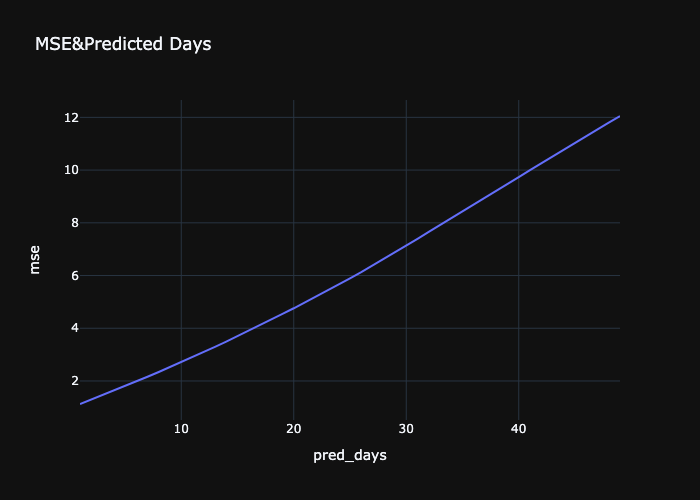

In [15]:
mses_df = pd.DataFrame(dict(mse = mses, pred_days =  [*range(1, 50)]))
fig = px.line(mses_df, x="pred_days", y="mse", title="MSE&Predicted Days")
fig.show('png')